Match and extract any SNIa observations from Pantheon + SH0ES with the SGA

In [6]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np

import matplotlib.pyplot as plt

# Load SGA data

We're going to start with the output from `data_match.ipynb`, so that all the distances are in the same file.

In [2]:
SGA = Table.read('SGA_distances.fits')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25
5002480,SGA-2020 5002480,DR8-2837p402-5033,-1,283.619631436471,40.3162008554537,DEV,178.80934,0.54342,0.3166,-1.0,24.29036,16.9862,False,DR8,530781,DR8-2837p402-5033,1,True,283.619631436471,40.3162008554537,0.54342,2837p402,283.6196056669463,40.316337272867564,0.53864765,SB26,179.53694,0.3690244,283.6194583471782,40.31653379127378,11.641381,11.157478,8.614751,9.8993,1.6142721,3.685578,5.5844307,7.701021,9.878292,11.927793,13.400182,14.697571,16.15943,21.37251,20.373438,19.779512,19.920574,19.005274,18.41066,19.314016,18.435898,17.843414,18.922651,18.076838,17.494484,18.664383,17.833265,17.25879,18.496494,17.682926,17.106598,18.404135,17.605488,17.02742,18.332602,17.555883,16.971588,18.299273,17.52499,16.931496,0.04933311,0.065890566,0.09742977,0.10495926,0.1614855,0.27832195,0.15179653,0.13904023,0.20484819,0.041657884,0.06669066,0.06785251,0.038538612,0.049561314,0.05101378,0.03635901,0.041818976,0.042013034,0.03367074,0.03763669,0.03705858,0.03122176,0.03420294,0.033616345,0.029198052,0.031941395,0.031132452,0.028080799,0.030865192,0.029955743,0.02722575,0.030135926,0.029090546,0.026788738,0.02959205,0.028436601,17.799881,1.3952494,0.83855844,

# Load Pantheon+SH0ES distance moduli

File from https://github.com/PantheonPlusSH0ES/DataRelease/tree/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR

In [3]:
SNIa = Table.read('cache/SN1A_dist/Pantheon+SH0ES.dat', 
                  format='ascii.commented_header')
SNIa[:5]

CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,USED_IN_SH0ES_HF,c,cERR,x1,x1ERR,mB,mBERR,x0,x0ERR,COV_x1_c,COV_x1_x0,COV_c_x0,RA,DEC,HOST_RA,HOST_DEC,HOST_ANGSEP,VPEC,VPECERR,MWEBV,HOST_LOGMASS,HOST_LOGMASS_ERR,PKMJD,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
str15,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
2011fe,51,0.00122,0.00084,0.00122,2e-05,0.00082,2e-05,9.74571,1.51621,28.9987,1.51645,29.177,1,0,-0.1076,0.04008,-0.548188,0.13373,9.58436,0.0327221,2.63181,0.0793177,0.00011378,-0.00052525,-0.00272765,210.774,54.2737,-999,-999,-9.0,0.0,250,0.00758935,10.677,-9.0,55815.0,0.1071,36,26.8859,0.86447,0.0991,1.496,0.0381,0.005,1.0,0.003
2011fe,56,0.00122,0.00084,0.00122,2e-05,0.00082,2e-05,9.80286,1.51723,29.0559,1.51747,29.177,1,0,-0.032895,0.038463,-0.380481,0.0861,9.78448,0.0352442,2.1888,0.0710511,-0.000443845,-0.00150198,-0.00220084,210.774,54.2737,-999,-999,-9.0,0.0,250,0.00758935,10.677,0.0,55815.2,0.0579,101,88.3064,0.81222,0.0971,1.496,-0.0252,0.003,1.0,0.004
2012cg,51,0.00256,0.00084,0.00256,2e-05,0.00144,2e-05,11.4703,0.781906,30.7233,0.782372,30.8433,1,0,0.10073,0.018231,0.49196,0.023545,11.8161,0.0237119,0.33695,0.00735879,-6.06025e-05,9.35054e-06,-0.000110842,186.803,9.4203,-999,-999,-9.0,0.0,250,0.0177724,9.633,0.002,56082.4,0.0278,165,233.5,0.000358347,0.0399,0.7134,0.0545,0.019,1.0,0.036
2012cg,56,0.00256,0.00084,0.00256,2e-05,0.00144,2e-05,11.4919,0.798612,30.7449,0.799068,30.8433,1,0,0.12247,0.03903,0.71261,0.083554,11.8801,0.0359611,0.31765,0.0105211,0.000222656,-0.000136637,-0.000344022,186.803,9.4203,-999,-999,-9.0,0.0,250,0.0177724,9.633,0.004,56082.4,0.0667,55,100.122,0.000193186,0.0931,0.7134,0.0622,0.028,1.0,0.04
1994DRichmond,50,0.00299,0.00084,0.00299,4e-05,0.00187,4e-05,11.5227,0.880798,30.7757,0.881212,-9.0,0,0,-0.111684,0.026044,-1.61803,0.049543,11.5334,0.0322548,0.43715,0.0129866,-9.88782e-05,-3.53658e-05,-0.000291408,188.51,7.7016,-999,-999,-9.0,0.0,250,0.0191036,8.46247,-9.0,49432.6,0.0522,146,109.839,0.98874,0.0567,0.611,0.065,0.009,1.0,0.006


# Match via sky position

We will consider a SN part of a galaxy if it is within that galaxy's $R_{26}$.

In [4]:
SGA_coords = SkyCoord(ra=SGA['RA']*u.deg, dec=SGA['DEC']*u.deg)

SNIa_coords = SkyCoord(ra=SNIa['RA']*u.deg, dec=SNIa['DEC']*u.deg)

In [5]:
idx, sep2d,_ = SNIa_coords.match_to_catalog_sky(SGA_coords)

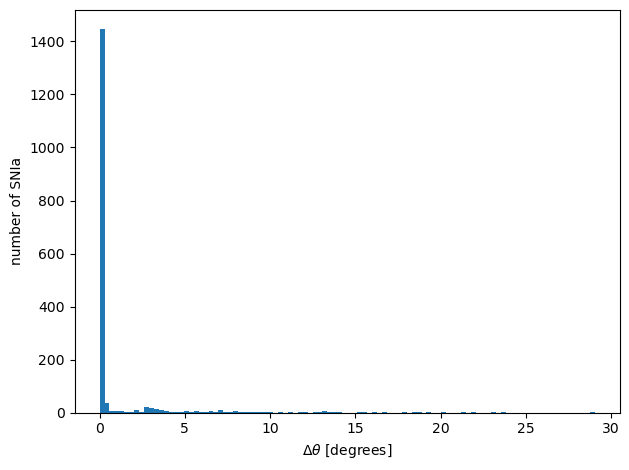

In [13]:
plt.figure(tight_layout=True)

plt.hist(sep2d.to(u.deg), bins=100)

plt.xlabel(r'$\Delta \theta$ [degrees]')
plt.ylabel('number of SNIa');

In [20]:
SGA['DM_PantheonSH0ES'] = np.nan
SGA['e_DM_PantheonSH0ES'] = np.nan
SGA['z_PantheonSH0ES'] = np.nan
SGA['e_z_PantheonSH0ES'] = np.nan
SGA['RA_PantheonSH0ES'] = np.nan
SGA['DEC_PantheonSH0ES'] = np.nan

# Valid matches
matches = sep2d.to(u.arcmin) < 0.5*SGA['D26'][idx]*u.arcmin

SGA['DM_PantheonSH0ES'][idx[matches]] = SNIa['MU_SH0ES'][matches]
SGA['e_DM_PantheonSH0ES'][idx[matches]] = SNIa['MU_SH0ES_ERR_DIAG'][matches]
SGA['z_PantheonSH0ES'][idx[matches]] = SNIa['zHEL'][matches]
SGA['e_z_PantheonSH0ES'][idx[matches]] = SNIa['zHELERR'][matches]
SGA['RA_PantheonSH0ES'][idx[matches]] = SNIa['RA'][matches]
SGA['DEC_PantheonSH0ES'][idx[matches]] = SNIa['DEC'][matches]

In [18]:
np.sum(np.isfinite(SGA['DM_PantheonSH0ES']))

318

In [19]:
SGA[['RA', 'DEC', 'z_PantheonSH0ES']][np.isfinite(SGA['DM_PantheonSH0ES'])].show_in_notebook()

idx,RA,DEC,z_PantheonSH0ES
0,16.84975791968929,32.40403223183585,0.01749
1,0.8958620610956882,23.200726856714155,0.02425
2,1.0063324460802996,-11.174295487734916,0.03761
3,1.451607253120829,27.449348263155745,0.02528
4,1.5593314530833227,8.887737461213659,0.03849
5,5.3433731447818635,22.433571232419247,0.02109
6,6.31978444708489,12.883866113740343,0.01765
7,9.751011519264168,-9.014585925754265,0.02038
8,10.46032011158196,-9.303116243899773,0.05311
9,10.465519374661358,32.99140987356976,0.01643


In [21]:
SGA.write('SGA_distances.fits', format='fits', overwrite=True)